# Pgnet Model with MVN Resampling

### TODO

- Move noDNA model to experimental
- Compile results for different models
- For pgnet, simulate with high n_res (10), but for inference can reduce 

- Simulate with small `dt`, inference with `dt` from Wilkinson paper. Do this for no DNA model

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers
# from pfjax.loglik_full import loglik_full
from pfjax import models
import optax
from functools import partial
import projplot as pjp

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import pgnet no DNA model from experimental

from pfjax.experimental.models import *
from pfjax import experimental

## Simulate Data

D1: 50, dt=1  
D4: n_obs = 100, dt = .5  
D5: n_obs = 500, dt = .1

In [3]:
key = random.PRNGKey(0)

_theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
_noise = 0.5
tau = np.array([1,1,1,1]) * _noise
theta = np.concatenate([_theta, tau])

dt = 0.1
n_res = 1
n_obs = 50

pgnet_bridge = models.PGNETModel(dt, n_res, bootstrap=False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_bridge, subkey, n_obs, x_init, theta)

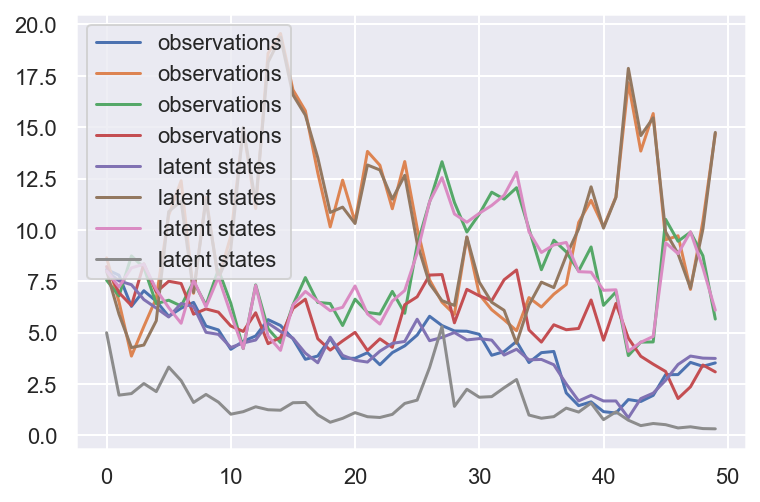

In [4]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [5]:
@jax.partial(jax.jit, static_argnums=(1,2, ))
def pf_neg_loglik_bridge(theta, model = pgnet_bridge, resampler = particle_resamplers.resample_mvn):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=pgnet_bridge, 
        y_meas=y_meas, 
        n_particles=n_particles, key=key,
        resampler = resampler)
    return -temp['loglik']


# @jax.partial(jax.jit, static_argnums=(1,2, 3, 4, ))
def particle_neg_loglik_mvn(theta, key, n_particles, y_meas, model):
    ret = pf.particle_filter(model, key, y_meas, theta, 
                             n_particles, 
                             resampler=particle_resamplers.resample_mvn)
    return -ret['loglik']


# @jax.partial(jax.jit, static_argnums=(1,2, 3, 4, ))
def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    ret = pf.particle_filter(model, key, y_meas, theta, 
                             n_particles)
    return -ret['loglik']


def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    loglik_value, params_update = jax.value_and_grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates), loglik_value


def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None, verbose = False):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
        if verbose: 
            print(f"Log-likelihood: {loglik_value}")
    return theta, losses, thetas


def stoch_opt(model, theta, grad_fun, y_meas, n_particles=100, 
              n_iter=10, learning_rate=0.01, key=1, mask=None):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    keys = random.split(key, n_iter)
    losses = []
    thetas = []
    for subkey in keys:
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas


def proj_data(fun, theta, theta_lims, theta_names, n_pts=100):
    """
    Create a DataFrame of projection plot data.

    For each element `i` of `theta`, evaluates `lambda x: fun([theta[:i], x, theta[i:]])` 
    for `x` linearly spaced between `theta_lims[i,0]` and `theta_lims[i,1]`.

    Args:
        fun: Function with argument `theta` returning a scalar.
        theta: Values onto which to project `fun()`.
        theta_lims: ndarray of size `theta.size x 2` giving the projection plot limits.
        theta_names: Names of the elements of `theta`.
        n_pts: Number of linearly spaced evaluation points.

    Returns:
        A DataFrame with columns:
            - id: Integers between 0 and `n_pts-1` giving the index of the point on the plot.
            - theta: Parameter name indicating which projection plot the data is for.
            - x: x-coordinate of the projection plot.
            - y: y-coordinate of the projection plot.
    """
    n_theta = theta_lims.shape[0]
    plot_data = np.empty((2, n_theta, n_pts))
    for i in range(n_theta):
        x_theta = np.linspace(theta_lims[i][0], theta_lims[i][1], num=n_pts)
        for j in range(n_pts):
            theta_tmp = np.copy(theta)
            theta_tmp[i] = x_theta[j]
            plot_data[0, i, j] = x_theta[j]
            plot_data[1, i, j] = fun(theta_tmp)
    col_names = ["x", "y"]
    return pd.merge(*[(pd.DataFrame(plot_data[i].T,
                                    columns=theta_names)
                       .assign(id=range(n_pts))
                       .melt(id_vars="id", var_name="theta", value_name=col_names[i])
                       ) for i in range(2)], on=["id", "theta"])


## DNA Observed

In [24]:
theta_lims = np.array([[0.05, 0.15], 
                       [0.5,1.], 
                       [0.1, 0.55],
                       [0.05, 0.45], 
                       [0.05, 0.25], 
                       [0.7, 1.], 
                       [0.01, 0.5], 
                       [0.01, 0.25],
                       [_noise - 0.1, _noise + 0.1], 
                       [_noise - 0.1, _noise + 0.1], 
                       [_noise - 0.1, _noise + 0.1], 
                       [_noise - 0.1, _noise + 0.1]])
#                        [5., 5.]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

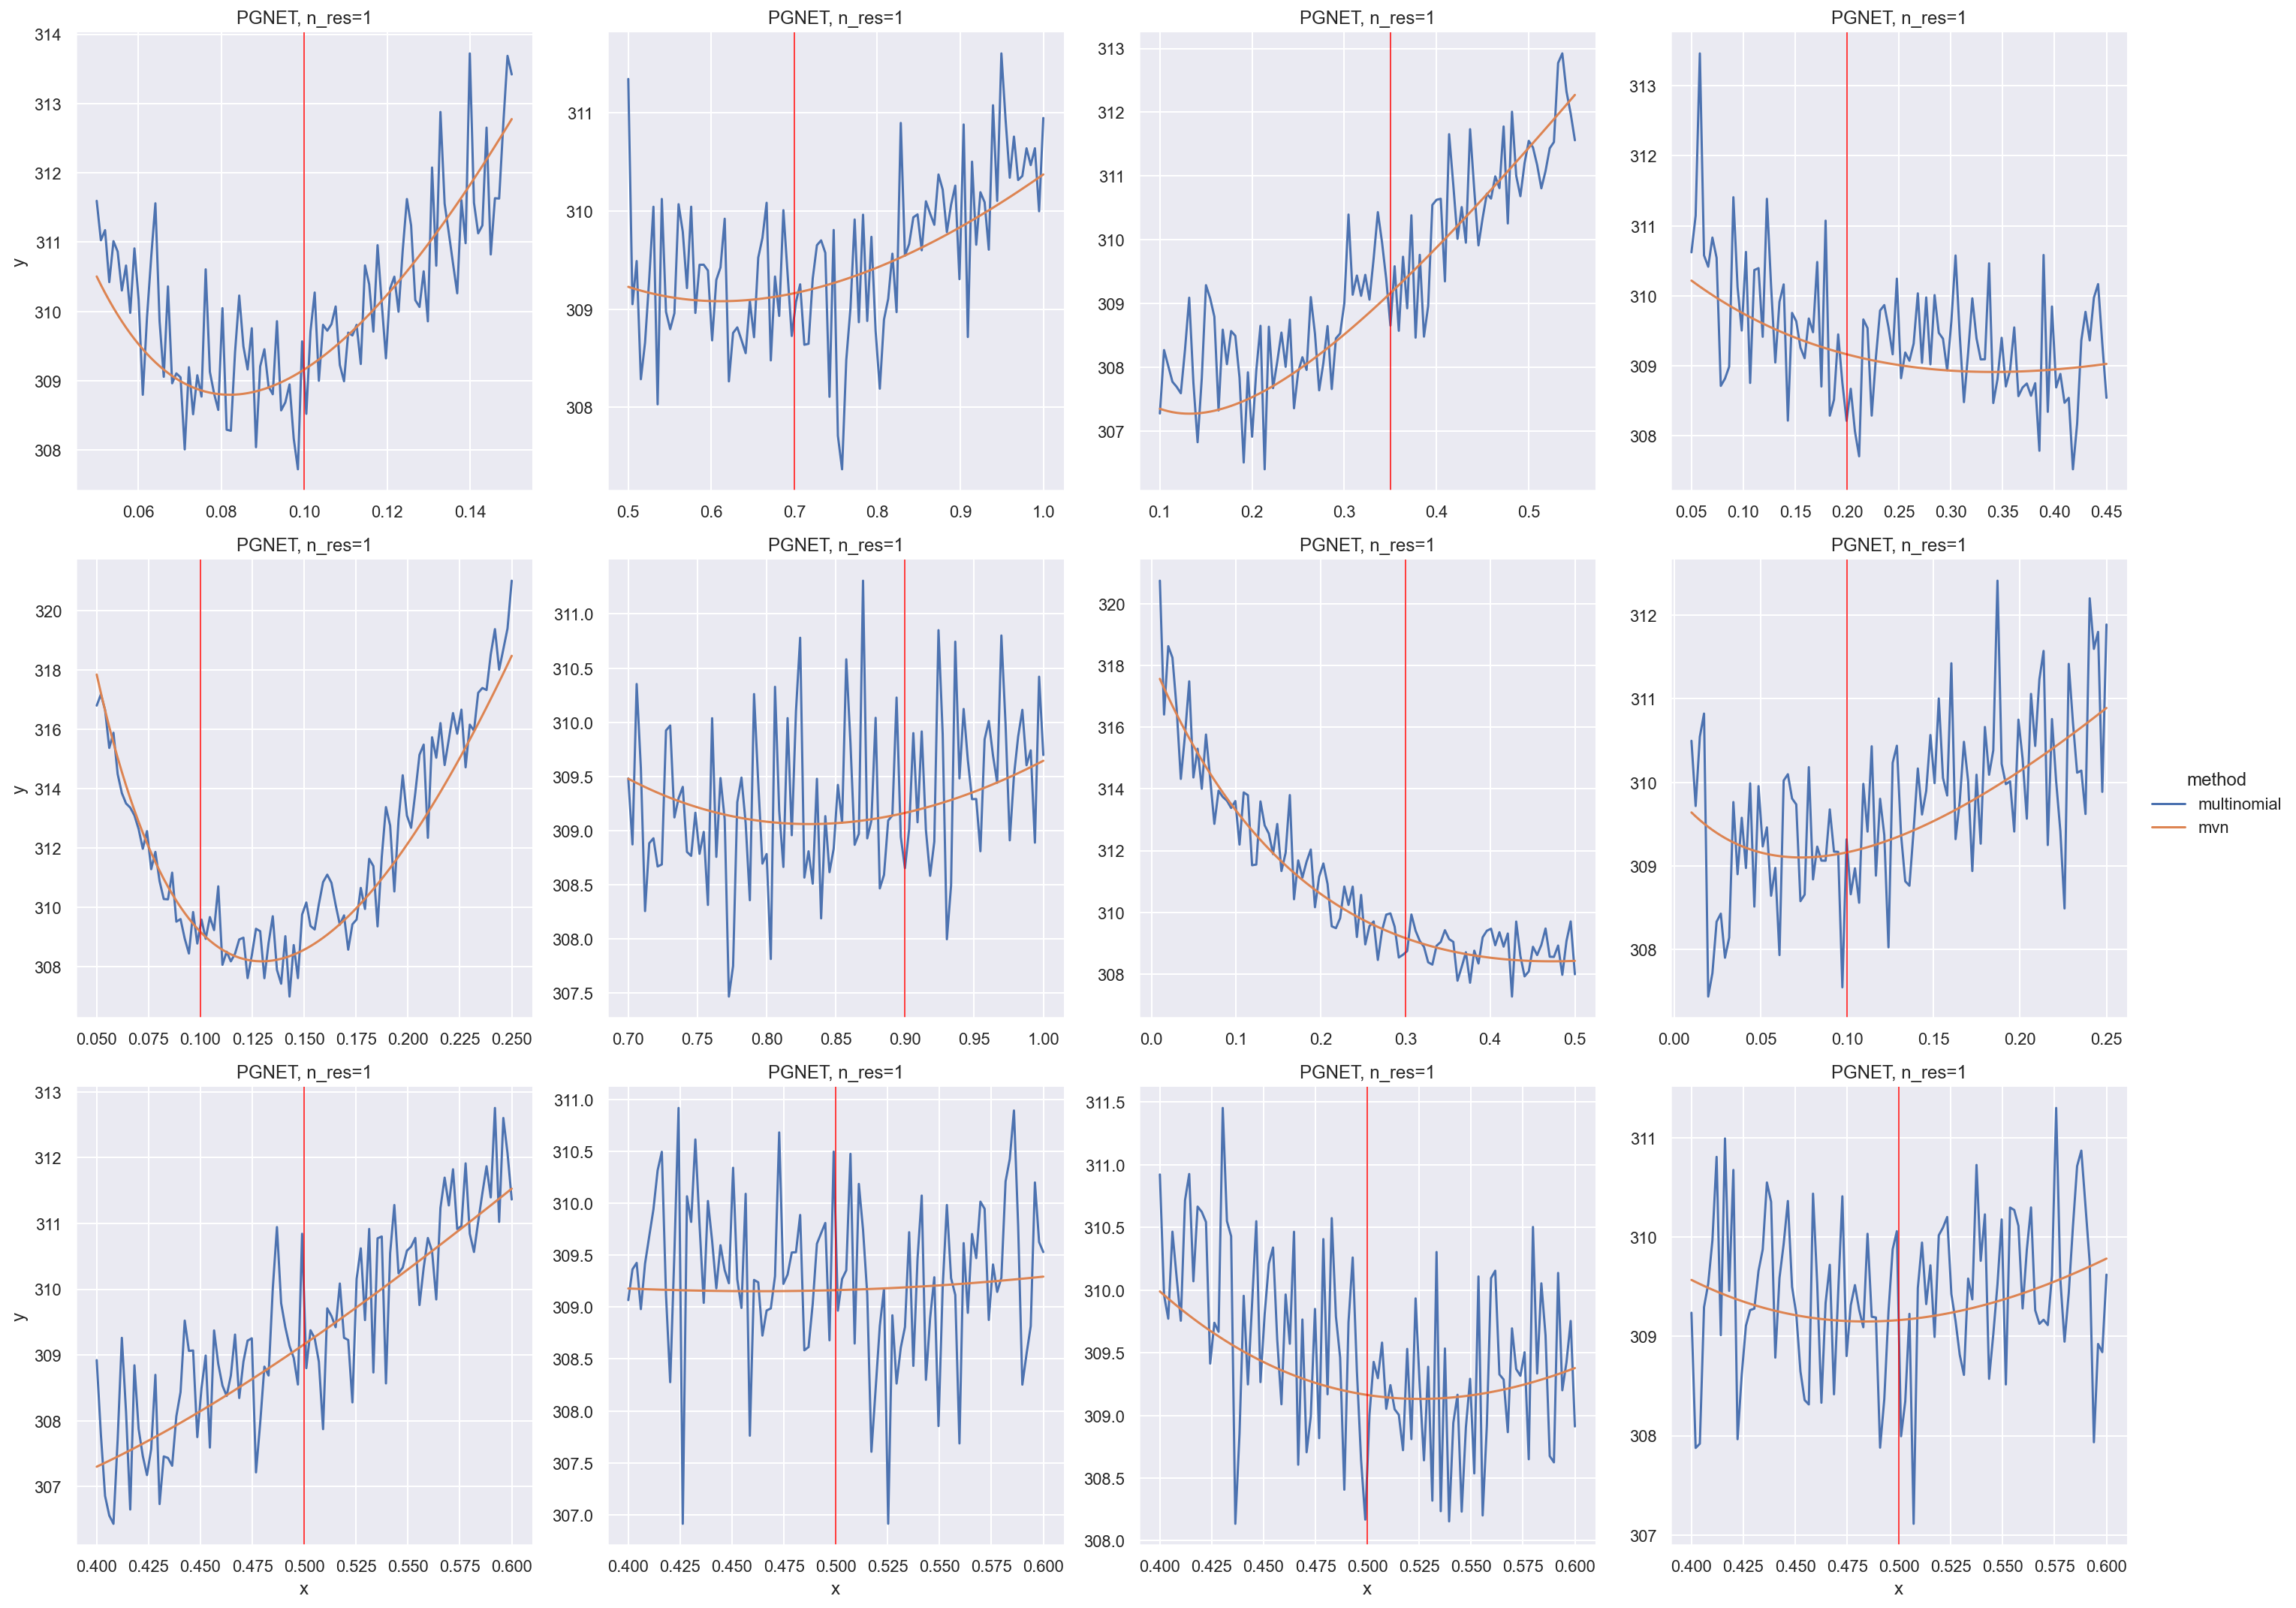

In [25]:
n_particles = 250

plot_mvn = proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x, resampler = pf.resample_multinomial),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title=f"PGNET, n_res={n_res}")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

In [29]:
# Fix parameters and run both filters with these: 
init_params = theta
n_particles = 250
n_iter = 50
learning_rate = 1e-3

mvn_params, mvn_losses, mvn_steps = simple_grad_descent(
    key = key,
    model = pgnet_bridge,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=jnp.concatenate([np.ones(8), np.zeros(4)]),
    verbose = False
)

print("Estimated params: ", mvn_params)

Estimated params:  [0.0820001  0.65000063 0.30000064 0.24999936 0.13599972 0.87000036
 0.34999937 0.05000027 0.5        0.5        0.5        0.5       ]


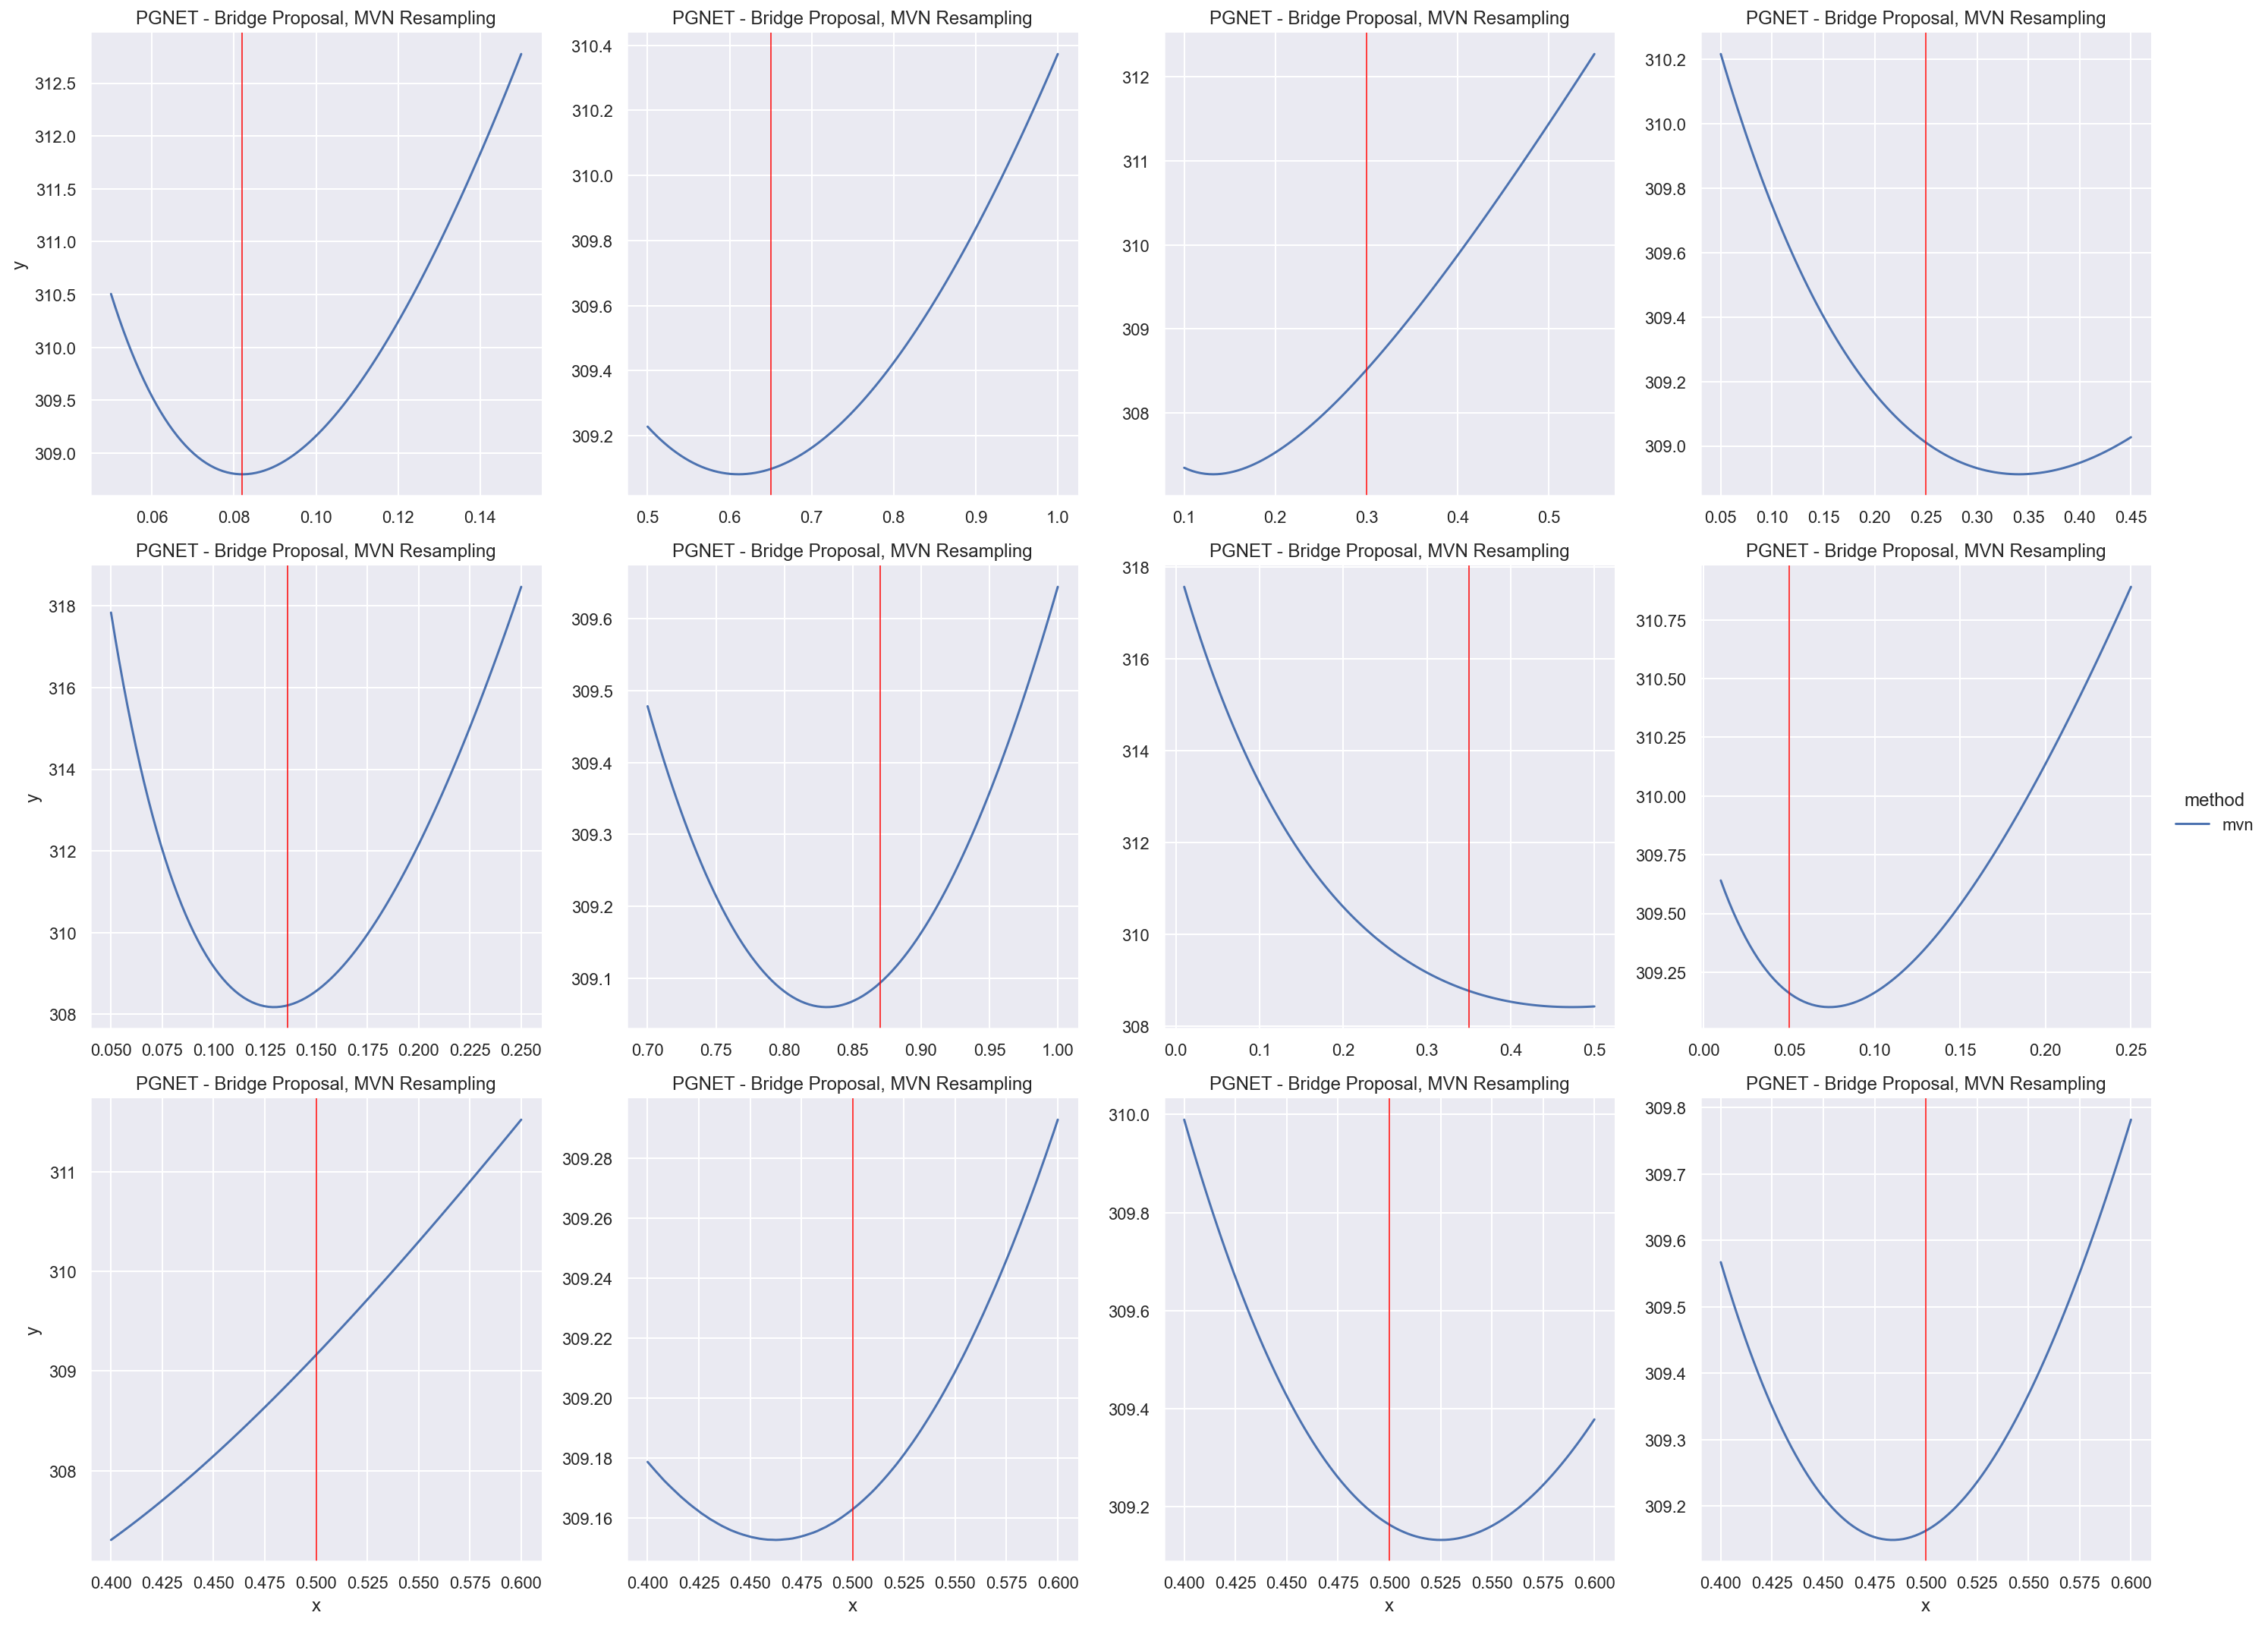

In [30]:
grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="PGNET - Bridge Proposal, MVN Resampling")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

## DNA Unobserved

- Particle for $X_{DNA}$ very unstable. Either very large positive or negative values. 

In [10]:
# key = random.PRNGKey(0)

# theta = jnp.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
# _noise = 0.5
# tau = jnp.array([1,1,1]) * _noise
# DNA_init = jnp.array([5.])

# theta = jnp.concatenate([theta, tau])#, DNA_init])

# dt = 0.1
# n_res = 1
# n_obs = 50

# pgnet_no_dna = PGNETModelNoDNA(dt, n_res, bootstrap=False)

# key, subkey = random.split(key)

# x_init = jnp.block([[jnp.zeros((n_res-1, 3))],
#                    [jnp.log(jnp.array([8., 8., 8.]))]])

# y_meas, x_state = pf.simulate(pgnet_no_dna, subkey, n_obs, x_init, theta)

key = random.PRNGKey(0)

_theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
_noise = 0.5
tau = np.array([1,1,1,1]) * _noise
theta = np.concatenate([_theta, tau])

dt = 0.1
n_res = 1
n_obs = 25

pgnet_bridge = models.PGNETModel(dt, n_res, bootstrap=False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_bridge, subkey, n_obs, x_init, theta)

In [11]:
# Simulate data with DNA observed model and do inference with DNA unobservedd: 
tau_unobserved = np.array([1,1,1]) * _noise
theta_unobserved = np.concatenate([_theta, tau_unobserved, np.array([np.log(5.)])])

pgnet_no_dna = PGNETModelNoDNA(dt, n_res, bootstrap=False)
# pgnet_no_dna2 = PGNETModelNoDNA_OLD(dt, n_res, bootstrap=False)

In [12]:
temp = pf.particle_filter(
    theta=theta_unobserved, 
    model=pgnet_no_dna, 
    y_meas=y_meas[:, :3], 
    n_particles=5e5, 
    key=key,
    resampler = particle_resamplers.resample_mvn)
temp

{'key': DeviceArray([3554317284,  360458010], dtype=uint32),
 'loglik': DeviceArray(nan, dtype=float32),
 'logw': DeviceArray([nan, nan, nan, ..., nan, nan, nan], dtype=float32),
 'x_particles': DeviceArray([[[nan, nan, nan, nan]],
 
              [[nan, nan, nan, nan]],
 
              [[nan, nan, nan, nan]],
 
              ...,
 
              [[nan, nan, nan, nan]],
 
              [[nan, nan, nan, nan]],
 
              [[nan, nan, nan, nan]]], dtype=float32)}

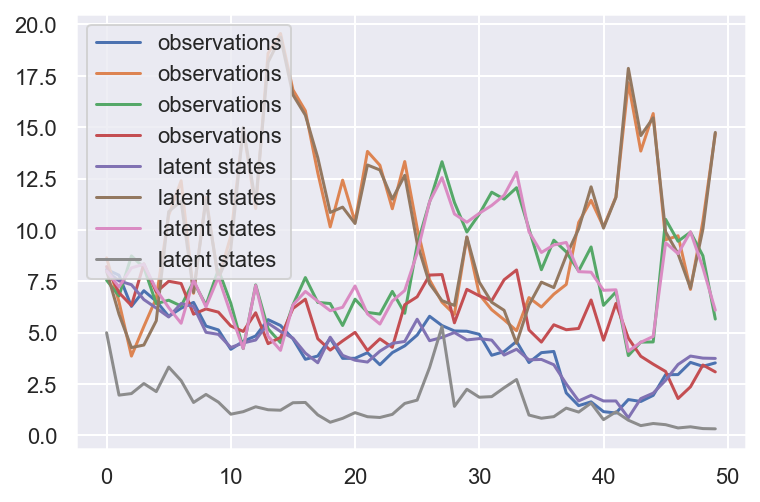

In [8]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [7]:
theta_lims = np.array([[0, 0.5], 
                       [0,1], 
                       [0, 1],
                       [0, 1], 
                       [0, 1], 
                       [0.5, 1], 
                       [0, 0.5], 
                       [0, 0.5],
                       [0.01, 2], 
                       [0.01, 2], 
                       [0.01, 2], 
                       [0.01, 2]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

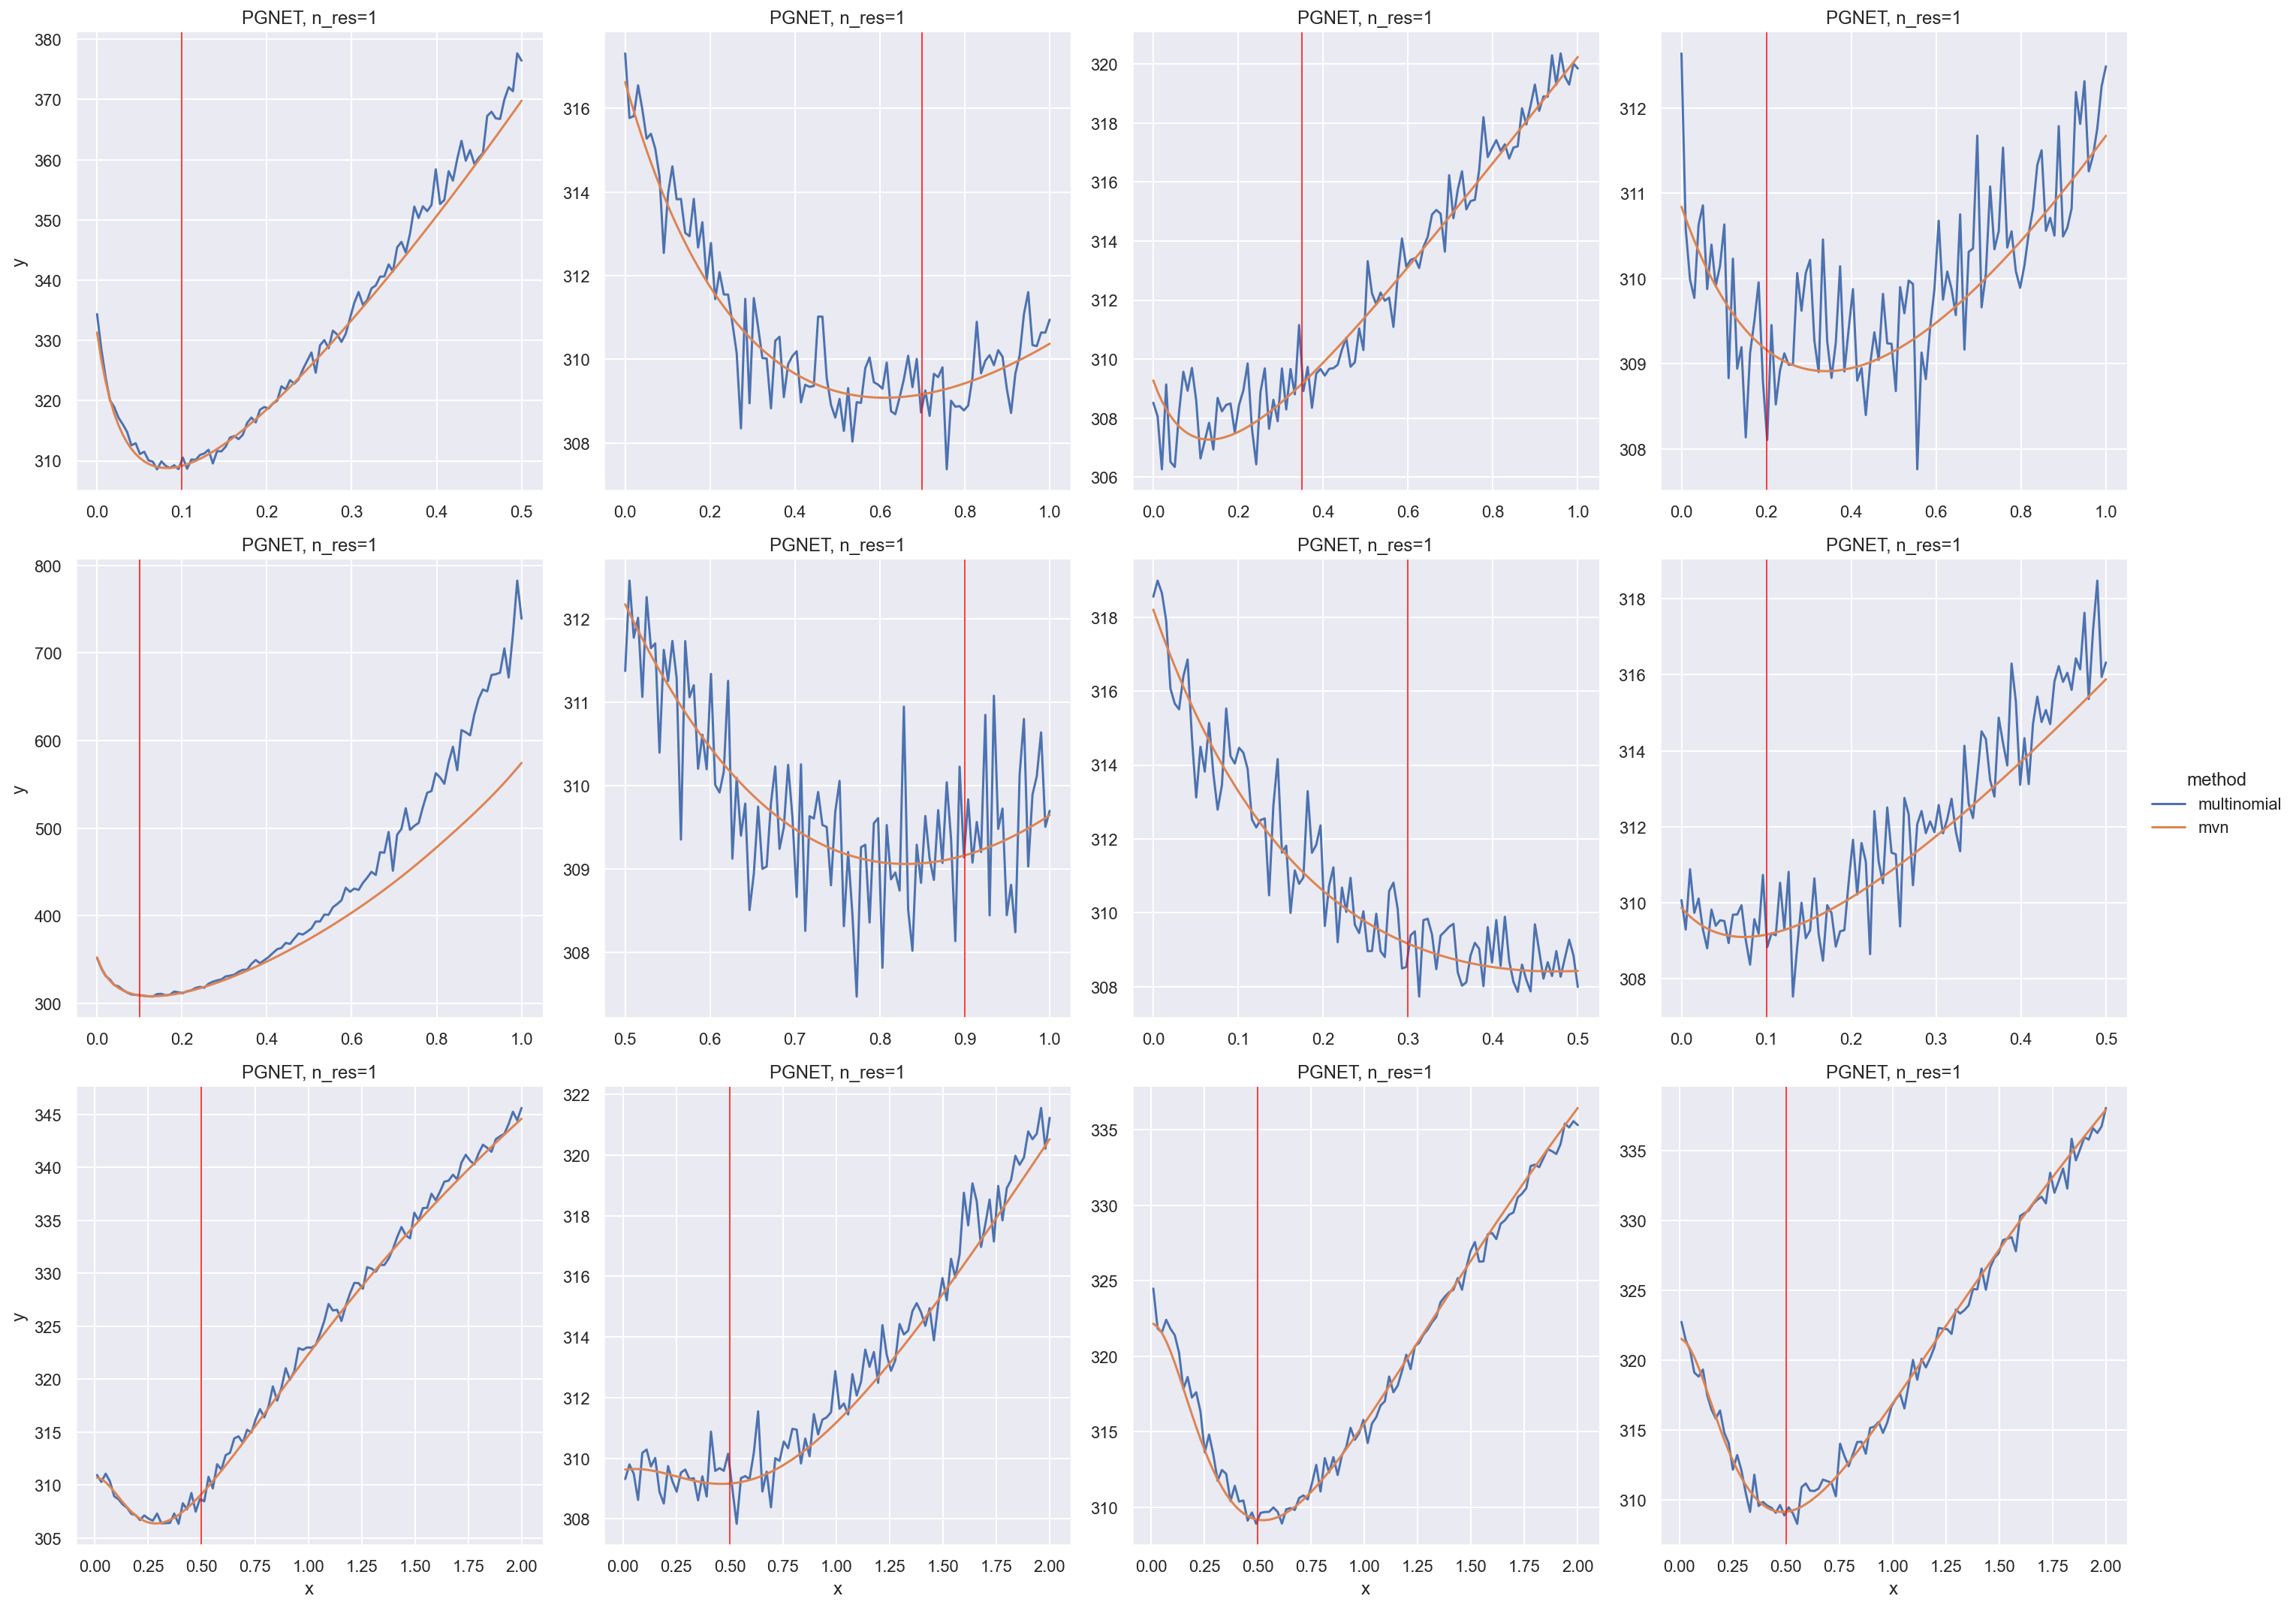

In [13]:
# particle_neg_loglik

n_particles = 250

plot_mvn = proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x, model = pgnet_no_dna), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x, model = pgnet_no_dna, resampler = particle_resamplers.resample_mvn),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title=f"PGNET, n_res={n_res}")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

In [9]:
init_params = jnp.array([0.05, 0.5, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1, 1., 1., .8, .8])
# init_params = theta
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [0.1  0.7  0.35 0.2  0.1  0.9  0.3  0.1  0.5  0.5  0.5  0.5 ]
Initial params:  [0.05 0.5  0.35 0.2  0.1  0.9  0.3  0.1  1.   1.   0.8  0.8 ]


In [9]:
temp = pf.particle_filter(
        theta=theta_unobserved, 
        model=pgnet_no_dna, 
        y_meas=y_meas[:, :3], 
        n_particles=250, 
    key=key,
        resampler = particle_resamplers.resample_mvn)

temp

logw:  -0.0
x_init:  Traced<ShapedArray(float32[4])>with<BatchTrace(level=1/0)>
  with val = DeviceArray([[ 1.9217584,  2.2149162,  1.9714537, -1.6512225],
                          [ 2.136137 ,  2.2684894,  2.1068525, -1.6512225],
                          [ 2.0882246,  2.126724 ,  2.1000457, -1.6512225],
                          [ 2.0656064,  2.1206198,  2.0395482, -1.6512225],
                          [ 2.1413133,  2.249436 ,  2.0545728, -1.6512225],
                          [ 2.001131 ,  2.1968255,  1.9150358, -1.6512225],
                          [ 2.0671437,  2.106377 ,  2.044657 , -1.6512225],
                          [ 2.0207822,  2.1130328,  1.9391387, -1.6512225],
                          [ 2.1842887,  2.1036828,  1.9955217, -1.6512225],
                          [ 1.9360455,  2.2141578,  2.0750778, -1.6512225],
                          [ 2.0365105,  2.1260653,  2.029594 , -1.6512225],
                          [ 2.0347276,  2.1632278,  2.0092676, -1.6512225],
        

filter init:  {'x_particles': DeviceArray([[[ 1.9217584,  2.2149162,  1.9714537, -1.6512225]],

             [[ 2.136137 ,  2.2684894,  2.1068525, -1.6512225]],

             [[ 2.0882246,  2.126724 ,  2.1000457, -1.6512225]],

             [[ 2.0656064,  2.1206198,  2.0395482, -1.6512225]],

             [[ 2.1413133,  2.249436 ,  2.0545728, -1.6512225]],

             [[ 2.001131 ,  2.1968255,  1.9150358, -1.6512225]],

             [[ 2.0671437,  2.106377 ,  2.044657 , -1.6512225]],

             [[ 2.0207822,  2.1130328,  1.9391387, -1.6512225]],

             [[ 2.1842887,  2.1036828,  1.9955217, -1.6512225]],

             [[ 1.9360455,  2.2141578,  2.0750778, -1.6512225]],

             [[ 2.0365105,  2.1260653,  2.029594 , -1.6512225]],

             [[ 2.0347276,  2.1632278,  2.0092676, -1.6512225]],

             [[ 1.9890187,  2.1555028,  2.0155637, -1.6512225]],

             [[ 2.1475966,  2.1272275,  2.0951912, -1.6512225]],

             [[ 1.9212241,  2.1748133,  2.0708

{'key': DeviceArray([3794760199, 3456105421], dtype=uint32),
 'loglik': DeviceArray(nan, dtype=float32),
 'logw': DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [13]:
temp = pf.particle_filter(
        theta=theta_unobserved, 
        model=pgnet_no_dna2, 
        y_meas=y_meas[:, :3], 
        n_particles=250, 
        key=key,
        resampler = particle_resamplers.resample_multinomial)

temp

filter init:  {'x_particles': DeviceArray([[[1.9217584, 2.2149162, 1.9714537, 0.475885 ]],

             [[2.136137 , 2.2684894, 2.1068525, 0.475885 ]],

             [[2.0882246, 2.126724 , 2.1000457, 0.475885 ]],

             [[2.0656064, 2.1206198, 2.0395482, 0.475885 ]],

             [[2.1413133, 2.249436 , 2.0545728, 0.475885 ]],

             [[2.001131 , 2.1968255, 1.9150358, 0.475885 ]],

             [[2.0671437, 2.106377 , 2.044657 , 0.475885 ]],

             [[2.0207822, 2.1130328, 1.9391387, 0.475885 ]],

             [[2.1842887, 2.1036828, 1.9955217, 0.475885 ]],

             [[1.9360455, 2.2141578, 2.0750778, 0.475885 ]],

             [[2.0365105, 2.1260653, 2.029594 , 0.475885 ]],

             [[2.0347276, 2.1632278, 2.0092676, 0.475885 ]],

             [[1.9890187, 2.1555028, 2.0155637, 0.475885 ]],

             [[2.1475966, 2.1272275, 2.0951912, 0.475885 ]],

             [[1.9212241, 2.1748133, 2.070861 , 0.475885 ]],

             [[1.995774 , 2.154076 , 2.0

{'key': DeviceArray([3794760199, 3456105421], dtype=uint32),
 'loglik': DeviceArray(nan, dtype=float32),
 'logw': DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [12]:
temp = pf.particle_filter(
        theta=theta, 
        model=pgnet_bridge, 
        y_meas=y_meas, 
        n_particles=250, 
        key=key,
        resampler = particle_resamplers.resample_mvn)

temp

filter init:  {'x_particles': DeviceArray([[[1.9217584 , 2.2149162 , 1.9714537 , 1.7227454 ]],

             [[2.136137  , 2.2684894 , 2.1068525 , 2.1366606 ]],

             [[2.0882246 , 2.126724  , 2.1000457 , 1.3066766 ]],

             [[2.0656064 , 2.1206198 , 2.0395482 , 1.8258398 ]],

             [[2.1413133 , 2.249436  , 2.0545728 , 1.9907453 ]],

             [[2.001131  , 2.1968255 , 1.9150358 , 2.1021605 ]],

             [[2.0671437 , 2.106377  , 2.044657  , 1.7106538 ]],

             [[2.0207822 , 2.1130328 , 1.9391387 , 1.4393169 ]],

             [[2.1842887 , 2.1036828 , 1.9955217 , 1.1748909 ]],

             [[1.9360455 , 2.2141578 , 2.0750778 , 1.8835016 ]],

             [[2.0365105 , 2.1260653 , 2.029594  , 1.5058225 ]],

             [[2.0347276 , 2.1632278 , 2.0092676 , 1.4856473 ]],

             [[1.9890187 , 2.1555028 , 2.0155637 , 1.4575652 ]],

             [[2.1475966 , 2.1272275 , 2.0951912 , 1.2096862 ]],

             [[1.9212241 , 2.1748133 , 2.07086

{'key': DeviceArray([3794760199, 3456105421], dtype=uint32),
 'loglik': DeviceArray(-309.16293, dtype=float32),
 'logw': DeviceArray([ -7.00974  ,  -7.9049716, -11.787379 , -11.225273 ,
              -10.699052 ,  -8.377344 ,  -9.506847 ,  -7.54233  ,
              -10.52399  ,  -7.6525044,  -9.095641 ,  -9.805227 ,
              -12.272569 ,  -7.605739 , -10.570568 ,  -9.1605   ,
               -6.6037393, -12.295883 ,  -8.943778 , -10.528669 ,
               -8.832085 , -12.415346 ,  -9.342411 , -11.461052 ,
               -9.015828 , -10.762903 ,  -9.106326 , -10.269493 ,
               -9.07188  ,  -9.544172 ,  -7.315631 ,  -6.716753 ,
               -8.721621 ,  -7.9885287, -12.000994 , -10.212273 ,
               -8.284385 ,  -9.539703 ,  -7.2181573, -10.302536 ,
               -7.8667693,  -9.278624 ,  -8.073227 , -10.058331 ,
               -9.464791 ,  -6.5585814,  -9.33819  , -10.129345 ,
               -8.312669 ,  -7.0526686,  -9.20673  , -10.017297 ,
              -11.3250

In [15]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 100
learning_rate = 1e-3

start = time.time()
mvn_params, mvn_losses, mvn_steps = simple_grad_descent(
    key = key,
    model = pgnet_no_dna,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params)),
    verbose = False
)

print("Time: ", time.time() - start)
print("Estimated params: ", mvn_params)

TypeError: div got incompatible shapes for broadcasting: (4,), (3,).

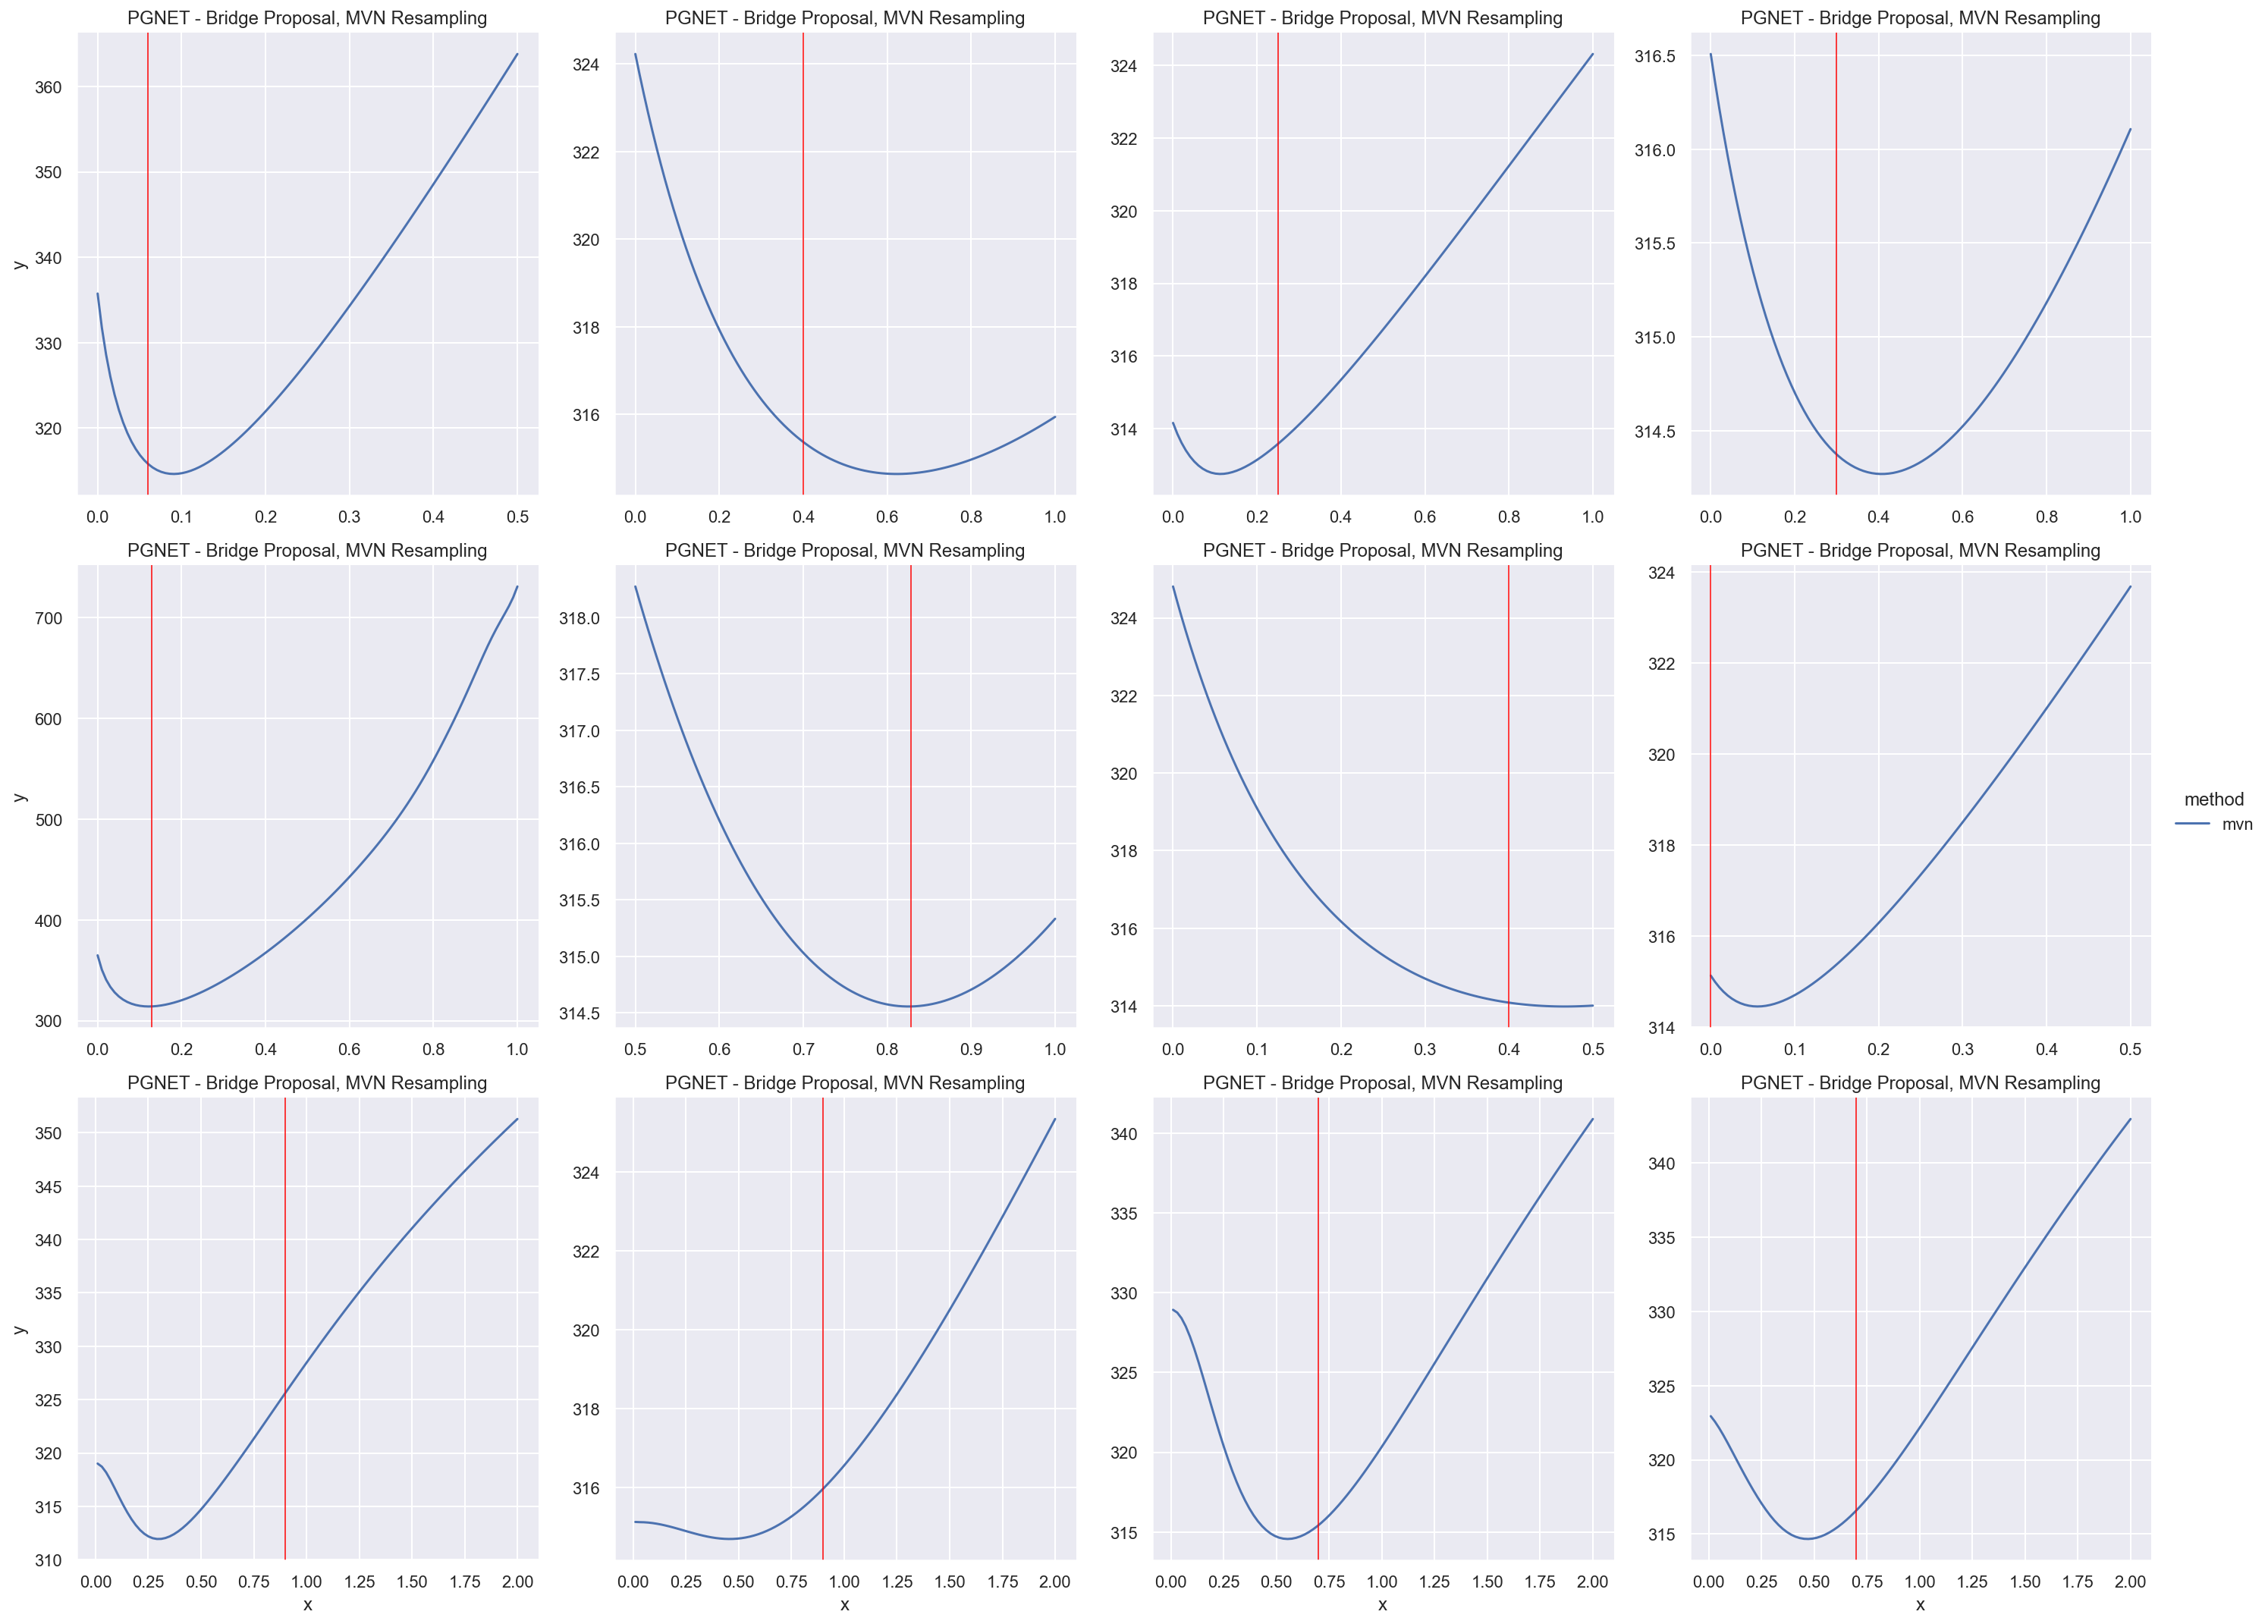

In [23]:
grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="PGNET - Bridge Proposal, MVN Resampling")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

In [16]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik_mvn))
hess = hessian_fn(
    mvn_params,
    key,
    n_particles=100,
    y_meas=y_meas,
    model=pgnet_bridge)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

Is positive definite?:  True


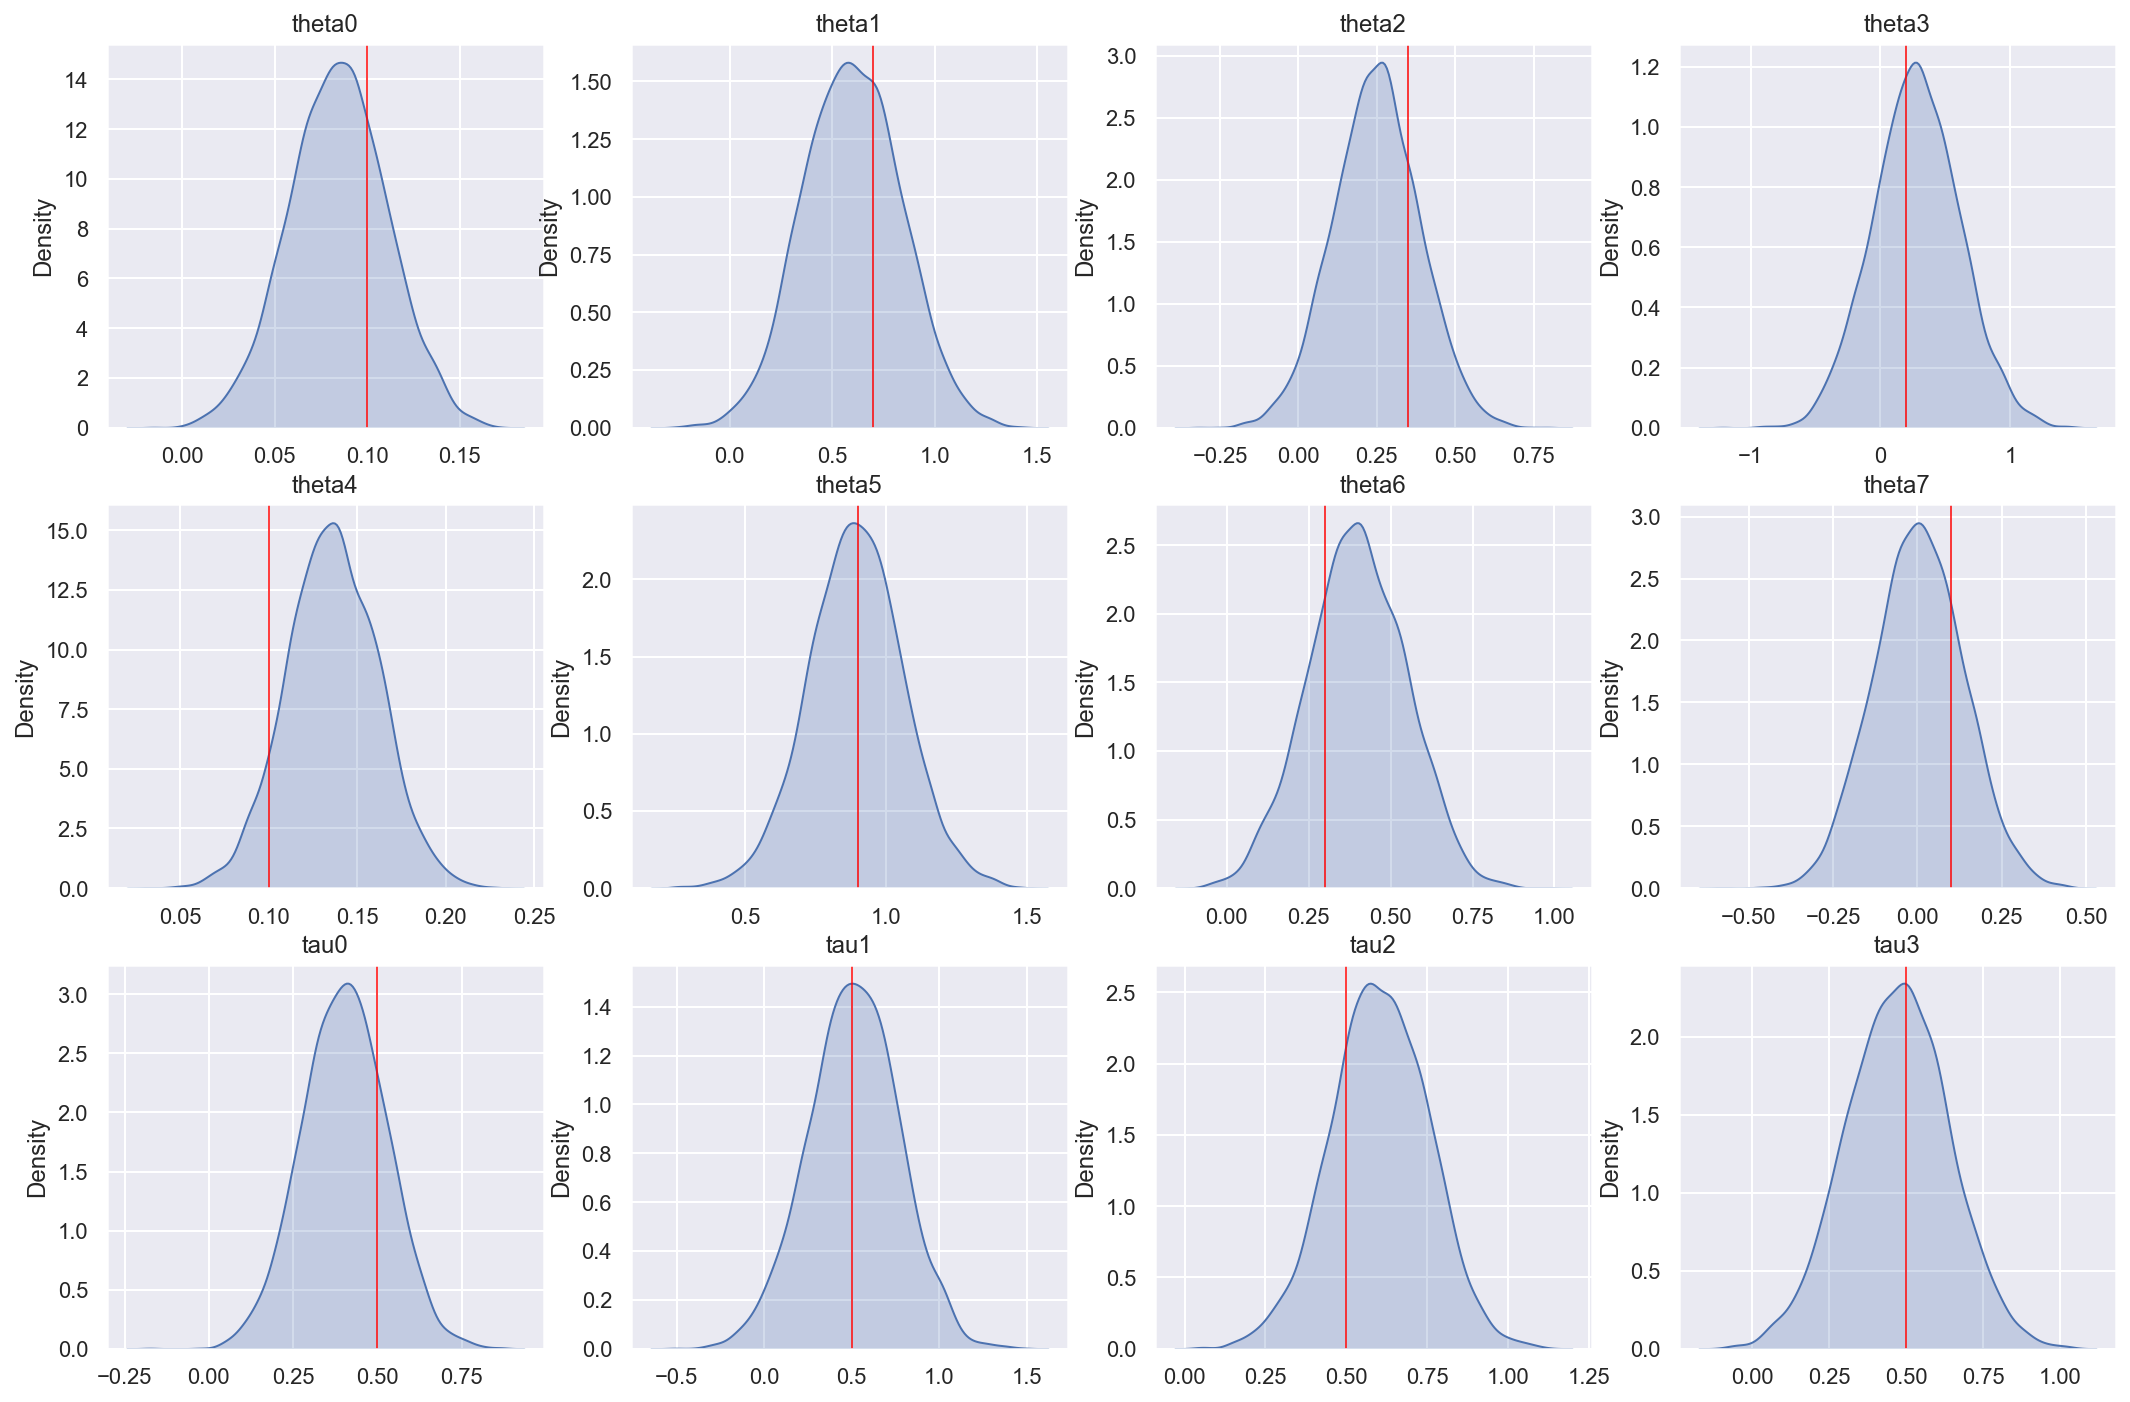

In [19]:
# var = jnp.linalg.inv(hess)
# mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

## Troubleshooting 

D1: 50, dt=1  
D4: n_obs = 100, dt = .5  
D5: n_obs = 500, dt = .1

- Figure out where this is happening. First the x_state goes to Inf, then y_meas. Figure out why x_state goes to Inf. 


- Sometimes one latent variable goes negative, which makes the diffusion negative definite
- 

In [ ]:
from jax.config import config

config.update("jax_enable_x64", False)

In [ ]:
key = random.PRNGKey(0)

theta = jnp.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
_noise = jnp.log(4.) #0.005
tau = jnp.array([1,1,1]) * _noise

DNA_init = jnp.array([5.])

theta = jnp.concatenate([theta, tau, DNA_init])
dt = 1
n_res = 1
n_obs = 50 # 50 

# pgnet_dna = models.PGNETModelNoDNA(dt, n_res)
pgnet_dna = models.PGNETModel(dt, n_res)
pgnet_dna_bridge = models.PGNETModelNoDNA(dt, n_res, bootstrap = False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_dna, subkey, n_obs, x_init, theta)

In [ ]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [ ]:
f_p = jnp.array([ 1.1612988, -0.7831085, 49.38876  ,  1.6880879])
print(jnp.outer(f_p, f_p))

In [ ]:
x_state